# 1) Import libraries and global variables

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pylab import meshgrid, cm, imshow, contour, clabel, colorbar, axis, title, show
import matplotlib.pyplot as plt

data_path = 'forumlog-22-03_2024.csv'

# 2) Feature extraction

We already upvotes. However, as proposed by the exercice, we can also add the number of post of the authors.

### Import raw data

In [2]:
data = pd.read_csv(data_path)
display(data.head())

,author,upvotes,label
0,73957,91,none
1,73957,269,none
2,73957,220,none
3,73957,102,good
4,73957,75,none


### Count the number of posts for each author and add the new column

In [3]:
#Count the number of times each user has posted in the forum
author_count = Counter(data['author'])


count_list = []
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    count_list.append(author_count[row['author']])

data['author_count'] = count_list
display(data.head())

100%|██████████| 101497/101497 [00:01<00:00, 82210.56it/s]


,author,upvotes,label,author_count
0,73957,91,none,16
1,73957,269,none,16
2,73957,220,none,16
3,73957,102,good,16
4,73957,75,none,16


### Save the new data

In [4]:
data.to_csv('data.csv', index=False)

# 3) Train a perceptron

### Import the data

In [5]:
data = pd.read_csv('data.csv')
print(data.shape)
display(data.head())

#Count the label
label_count = Counter(data['label'])
print(label_count)

(101497, 4)


,author,upvotes,label,author_count
0,73957,91,none,16
1,73957,269,none,16
2,73957,220,none,16
3,73957,102,good,16
4,73957,75,none,16


Counter({'none': 90551, 'spam': 10916, 'good': 30})


### Prepare train set and test set

In [6]:
#Keep only the rows with labels (i.e labels != "none")
data = data[data['label'] != 'none']

#Class imbalance -> Only take 37 spams and 37 goods
spam = data[data['label'] == 'spam']
good = data[data['label'] == 'good']
data = pd.concat([spam[:label_count["good"]], good[:label_count["good"]]])

#Split in train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)

#Add the rest of the spams and goods to the test set
test = pd.concat([test, spam[label_count["good"]:]])

#Numerize the labels : 1 = "spam", 0 = "good"
train['label'] = train['label'].apply(lambda x: 1 if x == 'spam' else 0)
test['label'] = test['label'].apply(lambda x: 1 if x == 'spam' else 0)

#Get X and y
X_train, y_train = train[['upvotes', 'author_count']], train['label']
X_test, y_test = test[['upvotes', 'author_count']], test['label']


#Convert y in numpy array
y_train = y_train.values
y_test = y_test.values

#Normalize X
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#PRINT
print("X_train shape:", X_train.shape)
print(X_train)
print("\ny_train shape:", y_train.shape)
print(y_train)
print("\nX_test shape:", X_test.shape)
print(X_test)
print("\ny_test shape:", y_test.shape)
print(y_test)

X_train shape: (48, 2)
[[ 2.54176965 -1.08807741]
 [-0.50999466  0.91986444]
 [ 0.1298914  -1.08373539]
 [-0.54280933  0.91986444]
 [-0.526402    0.91986444]
 [-0.69047535  0.91986444]
 [ 0.34318676 -1.08373539]
 [-0.60843867  0.91986444]
 [ 0.21192808 -1.08711251]
 [-0.50999466  0.91986444]
 [ 0.11348407 -1.09000719]
 [ 0.0806694  -1.0818056 ]
 [-0.64125334  0.91986444]
 [ 0.31037209 -1.09145453]
 [-0.72329002  0.91986444]
 [-0.65766068  0.91986444]
 [-0.65766068  0.91986444]
 [ 0.85181414 -1.08807741]
 [-0.60843867  0.91986444]
 [-0.59203134  0.91986444]
 [-0.50999466  0.91986444]
 [ 1.27840485 -1.09048964]
 [-0.65766068  0.91986444]
 [ 4.03483714 -1.08807741]
 [-0.06699662 -1.08373539]
 [ 0.32677942 -1.08711251]
 [ 0.21192808 -1.09000719]
 [-0.54280933  0.91986444]
 [-0.09981129 -1.08711251]
 [-0.62484601  0.91986444]
 [-0.50999466  0.91986444]
 [-0.59203134  0.91986444]
 [ 0.03144739 -1.08325294]
 [ 0.37600143 -1.08373539]
 [ 1.27840485 -1.09000719]
 [-0.50999466  0.91986444]
 [ 3.

### Visualize the data in a 2D map (as we have 2 features)

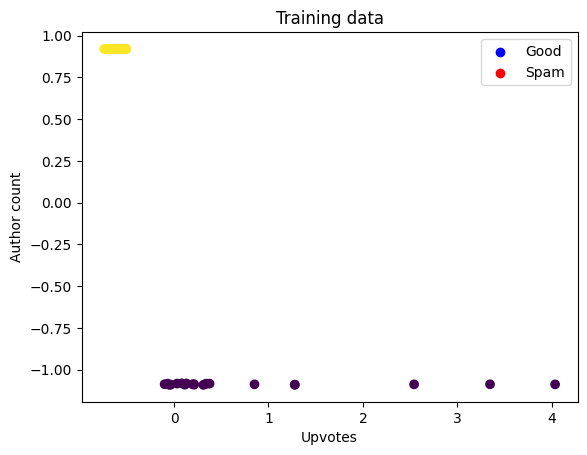

In [7]:
#visualize the training data
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.xlabel('Upvotes')
plt.ylabel('Author count')
plt.title('Training data')
#Legend
plt.scatter([], [], c='blue', label='Good')
plt.scatter([], [], c='red', label='Spam')
plt.legend()
plt.show()

### Create a custom Perceptron class

In [8]:
class Perceptron():

    def __init__(self, learning_rate=0.01, n_iters=None):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation = self.heaviside
        self.weights = None
        self.bias = None

    def forward(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activation(linear_output)
        return y_predicted

    def fit(self, X, y):

        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        if self.n_iters is None:
            self.n_iters = n_samples


        pbar = tqdm(range(self.n_iters), desc="Training the model...")
        for i in pbar:
            for j, x in enumerate(X):
                
                #Forward
                y_predicted = self.forward(x)
                
                #Gradient descent
                y_true = 1 if y[j] > 0 else 0
                self.weights += self.lr*(y_true - y_predicted)*x
                self.bias += self.lr*(y_true - y_predicted)
            
            if i%10 == 0 and i != 0:
                pbar.set_postfix({'loss': np.mean(np.square(y - self.forward(X)))}) 



    def predict(self, X):
        return self.forward(X)

    def heaviside(self, x): #Heaviside function
        return np.where(x >= 0, 1, 0)

### Train the model

In [9]:
model = Perceptron(learning_rate=0.01)

model.fit(X_train, y_train)


Training the model...: 100%|██████████| 48/48 [00:00<00:00, 1391.74it/s, loss=0]


### Test the model

Accuracy: 0.8747476601211231
Precision: 1.0
Recall: 0.8746556473829201
F1 score: 0.9331373989713446


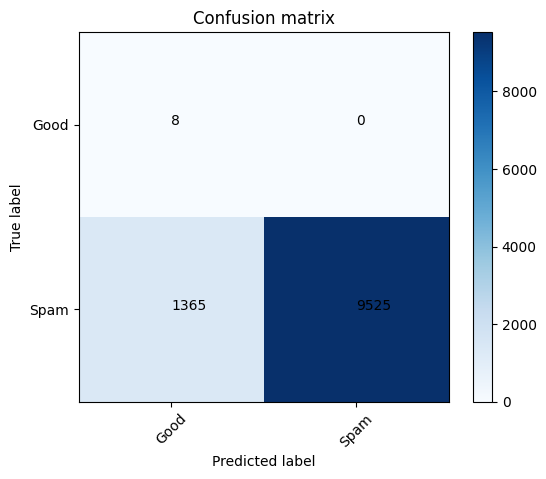

In [17]:
#Confusion matrix
def confusion_matrix(y_true, y_pred):
    TP = np.sum(y_true * y_pred)
    TN = np.sum((y_true == 0) * (y_pred == 0))
    FP = np.sum((y_true == 0) * (y_pred == 1))
    FN = np.sum((y_true == 1) * (y_pred == 0))
    return TP, TN, FP, FN

#Accuracy
def accuracy(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
    return (TP + TN) / (TP + TN + FP + FN)

#Precision
def precision(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
    return TP / (TP + FP)

#Recall
def recall(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix(y_true, y_pred)
    return TP / (TP + FN)

#F1 score
def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec)

#Predictions
y_pred = model.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

#Metrics
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 score:", f1)


#Plot the confusion matrix
TP, TN, FP, FN = confusion_matrix(y_test, y_pred)
conf_matrix = np.array([[TN, FP], [FN, TP]])

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Good', 'Spam'], rotation=45)
plt.yticks(tick_marks, ['Good', 'Spam'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j])
plt.show()


# 4) XAI to check our intuition

In [13]:
#Model parameters
print("Weights:", model.weights)
print("Bias:", model.bias)

Weights: [-0.0254177   0.01088077]
Bias: -0.01


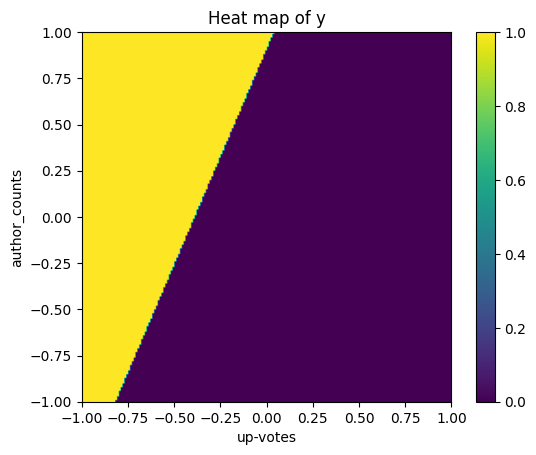

In [12]:
x1 = np.arange(-1,1,0.01)
x2 = np.arange(-1,1,0.01)
X1,X2 = meshgrid(x1, x2) # grid of point

#Shape as a 3D array
X = np.array([X1.ravel(), X2.ravel()]).T

#Predict
y = model.predict(X)

#Reshape
y = y.reshape(X1.shape)

#Heat map of y
plt.figure()
imshow(y, extent=(-1,1,-1,1), origin='lower')
title('Heat map of y')
#Legend axis
plt.xlabel("up-votes")
plt.ylabel("author_counts")
colorbar()
plt.show()


Interpretation : posts whose authors published is more likely to be label as spam. The decision boundary is linear and is increasing -> Even if author published a lot, if their posts is often up-voted, it is more likely to be good.